In [1]:
import torch

In [2]:
SEED = 1
torch.manual_seed(SEED)
import random
random.seed(SEED)

In [3]:
from igre_dqn_v2 import IgreDQNTrainer
from igre_v1 import Igre

/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import AutoTokenizer
from based.models.gpt import GPTLMHeadModel

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPTLMHeadModel.from_pretrained_hf("hazyresearch/based-360m")

based_model = model.transformer
lm_head = model.lm_head

No module named 'causal_attention_cuda'
Successfully imported the causal dot product kernel! 
Successfully imported the FLA triton kernels! 


# Load Sim4 data

In [5]:
import json
import pickle

In [6]:

sim_4_training_data_unpickled = pickle.load(open("sim4_data2.pkl", "rb"))
len(sim_4_training_data_unpickled)

90

In [7]:
sim_4_training_data_unpickled[1].actor

# Training

In [8]:
model = Igre(based_model, lm_head, tokenizer)
model.cuda()
model.train()

/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Igre(
  (encoder): IEncoderBased(
    (based_model): GPTModel(
      (embeddings): GPT2Embeddings(
        (word_embeddings): Embedding(50264, 1024)
      )
      (layers): ModuleList(
        (0): Block(
          (mixer): BaseConv(
            (in_proj): Linear(in_features=1024, out_features=4096, bias=True)
            (out_proj): Linear(in_features=2048, out_features=1024, bias=True)
            (conv): ShortConvolution(
              (conv): Conv1d(2048, 2048, kernel_size=(3,), stride=(1,), padding=(2,), groups=2048, bias=False)
            )
          )
          (dropout1): Dropout(p=0, inplace=False)
          (drop_path1): StochasticDepth(p=0.0, mode=row)
          (norm1): RMSNorm()
          (mlp): GatedMlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=False)
            (fc2): Linear(in_features=2048, out_features=1024, bias=False)
          )
          (dropout2): Dropout(p=0, inplace=False)
          (drop_path2): StochasticDepth(p=0.0, mode=row)
  

In [9]:
DEBUG_NAN = True
def check_activation_for_nan(name):
    def hook(model, input, output):
        if type(output) is tuple:
            for i, out in enumerate(output):
                if type(out) is torch.Tensor and torch.isnan(out).any():
                    print(f"Found NaN in {name}[{i}]")
        elif type(output) is torch.Tensor:
            if torch.isnan(output).any():
                print(f"Found NaN in {name}")
    return hook
if DEBUG_NAN:
    for name, module in model.named_modules():
        module.register_forward_hook(check_activation_for_nan(name))

In [10]:
dqn_trainer = IgreDQNTrainer(model)

In [11]:
import random
import re

teacher_forcing_count = 0

def get_completion(prompt):
    global teacher_forcing_count
    prompt_ids = tokenizer.encode(prompt, return_tensors="pt").cuda()
    response_ids, z = dqn_trainer.get_response(prompt_ids)
    metadata = {
        "z": z,
        "response_ids": response_ids.detach().cpu()
    }
    # use_teacher_forcing = random.random() < 0.5
    # if use_teacher_forcing and teacher_forcing_count < 100:
    #     teacher_forcing_count += 1
    #     print("use teacher forcing")
    #     finish_X_re = re.compile(" finish ([ABCD])")
    #     match = finish_X_re.search(prompt)
    #     if match:
    #         finish_X = match.group(0).strip()
    #         return finish_X, metadata
    print("completion response ids")
    print(response_ids)
    response = tokenizer.decode(response_ids.squeeze(0), skip_special_tokens=True)
    # if '"' in response or "'" in response:
    #     # Remove quotes
    #     response = response.replace('"', "")
    #     response = response.replace("'", "")
    #     response_ids = tokenizer.encode(response, return_tensors="pt").cuda()
    return tokenizer.decode(response_ids.squeeze(0), skip_special_tokens=True), metadata

In [12]:
get_completion("test")

DEBUG GENERATE
seq_cat tensor([[9288]], device='cuda:0')
test
DEBUG SAMPLE TOKENS
token tensor([532], device='cuda:0')
logit at token tensor([9.2419], device='cuda:0')
max logit tensor(9.2419, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[9288,  532]], device='cuda:0')
test -
DEBUG SAMPLE TOKENS
token tensor([532], device='cuda:0')
logit at token tensor([10.3626], device='cuda:0')
max logit tensor(10.3626, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[9288,  532,  532]], device='cuda:0')
test - -
DEBUG SAMPLE TOKENS
token tensor([532], device='cuda:0')
logit at token tensor([11.3673], device='cuda:0')
max logit tensor(11.3673, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[9288,  532,  532,  532]], device='cuda:0')
test - - -
DEBUG SAMPLE TOKENS
token tensor([532], device='cuda:0')
logit at token tensor([12.4585], device='cuda:0')
max logit tensor(12.4585, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[9288,  532,  532,  532,  532]], device='cuda:0')
test - - - -
DEBUG SAMPLE

(' - - - - - - - - -',
 {'z': tensor([[-0.6576,  0.0202,  0.7125,  ..., -0.1541, -0.1631, -0.3022]],
         device='cuda:0'),
  'response_ids': tensor([[532, 532, 532, 532, 532, 532, 532, 532, 532]])})

In [13]:
from simulation.sim_runner import SimRunner
from simulation.common.base_actor import AIActor

modules
['/home/mocuto/code/mamba-chat/simulation/sim4/__init__.py', '/home/mocuto/code/mamba-chat/simulation/sim3/__init__.py', '/home/mocuto/code/mamba-chat/simulation/sim0/__init__.py']
y
simulation.sim4
y
simulation.sim3
y
simulation.sim0


In [14]:
def process_transition(transition, finetune=False, finetune_state_to_prompt_fn=None):
    assert finetune == False or (finetune == True and finetune_state_to_prompt_fn is not None)
    def inner(prompt, response, next_state_prompt):
        prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
        response_ids = tokenizer.encode(
            response, return_tensors="pt", add_special_tokens=False
        ).long()
        # Add eos token to response_ids
        response_ids = torch.cat([response_ids, torch.tensor([[tokenizer.eos_token_id]], dtype=torch.long)], dim=1).long()  # type: ignore

        next_state_prompt_ids = tokenizer.encode(
            next_state_prompt, return_tensors="pt", add_special_tokens=True
        ).long()

        act_metadata = transition.action.metadata
        z = torch.zeros(1)
        if act_metadata is not None and "z" in act_metadata:
            z = act_metadata["z"]
        if act_metadata is not None and "response_ids" in act_metadata:
            response_ids = act_metadata["response_ids"]
            response_ids = torch.cat([response_ids, torch.tensor([[tokenizer.eos_token_id]], dtype=torch.long)], dim=1).long()  # type: ignore

        reward = (transition.next_state.score - transition.state.score) / 100
        reward = torch.tensor([reward]).float().detach()

        next_state_is_terminal = torch.tensor([1. if transition.next_state.is_terminal else 0.])

        print(f"prompt: {prompt}")
        print(f"response: {response}")
        dqn_trainer.add_transition(
            prompt_ids.squeeze(0),
            response_ids.squeeze(0),
            z,
            reward,
            next_state_prompt_ids.squeeze(0),
            next_state_is_terminal,
            add_to_finetune_memory=finetune,
        )
    if finetune:
        # Check the classname for "player"
        if "player" in transition.actor.__class__.__name__.lower():
            assert finetune_state_to_prompt_fn is not None
            prompt = finetune_state_to_prompt_fn(transition.state)
            response = transition.action.content
            next_state_prompt = finetune_state_to_prompt_fn(transition.next_state)
            inner(prompt, response, next_state_prompt)
    else:
        if isinstance(transition.actor, AIActor) and transition.actor.name == "player":
            prompt = transition.action.completion_prompt
            response = transition.action.completion_response

            print("## DEBUG prompt")
            print(prompt)
            prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
            print(prompt_ids)

            next_state = transition.next_state
            next_state_prompt = transition.actor.state_to_prompt(next_state)
            inner(prompt, response, next_state_prompt)

        # prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
        # response_ids = tokenizer.encode(
        #     response, return_tensors="pt", add_special_tokens=False
        # ).long()
        # # Add eos token to response_ids
        # response_ids = torch.cat([response_ids, torch.tensor([[tokenizer.eos_token_id]], dtype=torch.long)], dim=1).long()  # type: ignore

        # next_state_prompt_ids = tokenizer.encode(
        #     next_state_prompt, return_tensors="pt", add_special_tokens=False
        # ).long()

        # z = transition.action.metadata["z"]
        # reward = transition.next_state.score - transition.state.score
        # reward = torch.tensor([reward])
        # print(f"prompt: {prompt}")
        # print(f"response: {response}")
        # dqn_trainer.add_transition(
        #     prompt_ids.squeeze(0),
        #     response_ids.squeeze(0),
        #     z,
        #     reward,
        #     next_state_prompt_ids.squeeze(0),
        #     transition.next_state.is_terminal,
        # )

In [15]:
sim_name = "sim4"
sim_runner = SimRunner(
    sim_name=sim_name,
    seed=1,
    model_forward_func_for_ai={
        "player": get_completion,
    },
)

## Process transitions using the player actor in the sim

In [16]:
ai_actor = None
for actor in sim_runner.sim.actors:
    if isinstance(actor, AIActor):
        ai_actor = actor
        break
ai_actor

In [17]:
dqn_trainer.reset_memory(finetune=True)
for x in sim_4_training_data_unpickled:
    process_transition(x, finetune=True, finetune_state_to_prompt_fn=ai_actor.state_to_prompt)
    process_transition(x, finetune=True, finetune_state_to_prompt_fn=ai_actor.state_to_prompt)
    process_transition(x, finetune=True, finetune_state_to_prompt_fn=ai_actor.state_to_prompt)
len(dqn_trainer.finetune_memory)

prompt: 
You are to solve the an algebraic expression.
You have access to two commands:
- 'calc <expression>' to calculate the value of an expression. <expression> must be in the form 'a + b' where a and b are integers.
- 'finish <solution>' to submit your answer. <solution> must be in the form '<letter> = <number>' where <letter> is the letter used in the problem and <number> is the solution.
The following is the algebraic expression:
x = 13 + 22
What is the value of x?
When you have an answer, use the 'finish' command to submit your answer.




player:
response: calc 13 + 22
## DEBUG tmp: actor_log_probs * response_mask[:, 1:]
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.

/home/mocuto/code/mamba-chat/igre_dqn_v2.py:286: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(tmp.detach().cpu(), reward.view(-1, 1)).detach().cpu().item()


## DEBUG tmp: actor_log_probs * response_mask[:, 1:]
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0

90

In [18]:


def run():
    sim_runner.reset(seed=1)
    print("## DEBUG sim run len")
    print(len(sim_runner.history))
    while not sim_runner.get_state().is_terminal:
        transitions = sim_runner.step()
        for x in transitions:
            if isinstance(x.actor, AIActor) and x.actor.name == "player":
                process_transition(x)
    print("done")
    final_transitions = sim_runner.final()
    did_win = False
    for x in final_transitions:
        process_transition(x)
        if x.next_state.score > 0:
            did_win = True
    return did_win

run()

## DEBUG sim run len
0
DEBUG GENERATE
seq_cat tensor([[  198,  1639,   389,   284,  8494,   262,   281, 37139,   291,  5408,
            13,   198,  1639,   423,  1895,   284,   734,  9729,    25,   198,
            12,   705,  9948,    66,  1279, 38011,    29,     6,   284, 15284,
           262,  1988,   286,   281,  5408,    13,  1279, 38011,    29,  1276,
           307,   287,   262,  1296,   705,    64,  1343,   275,     6,   810,
           257,   290,   275,   389, 37014,    13,   198,    12,   705, 15643,
           680,  1279,    82,  2122,    29,     6,   284,  9199,   534,  3280,
            13,  1279,    82,  2122,    29,  1276,   307,   287,   262,  1296,
           705,    27,  9291,    29,   796,  1279, 17618,    29,     6,   810,
          1279,  9291,    29,   318,   262,  3850,   973,   287,   262,  1917,
           290,  1279, 17618,    29,   318,   262,  4610,    13,   198,   464,
          1708,   318,   262, 37139,   291,  5408,    25,   198,    87,   796,
      

False

In [19]:
tokenizer.eos_token_id

50256

In [20]:
import matplotlib.pyplot as plt
from IPython import display
import time

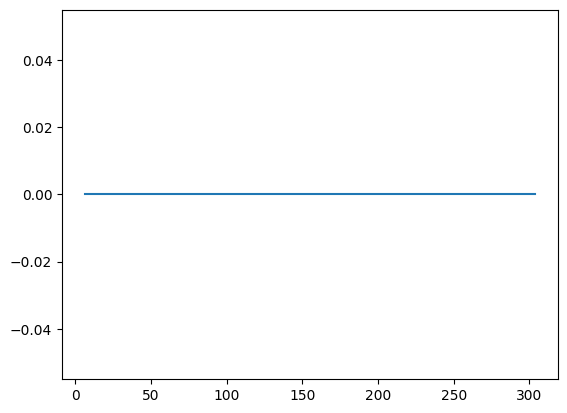

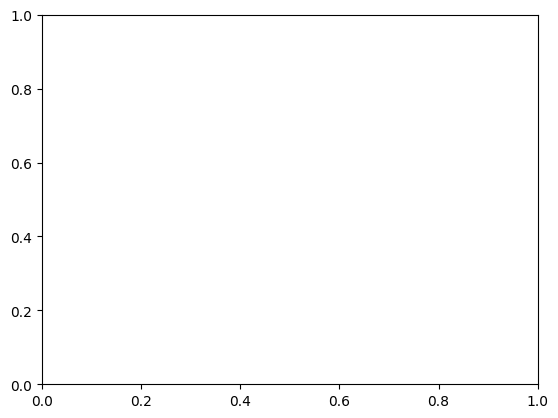

In [21]:
%matplotlib inline

def pltsin(ax, fig, x, y, hdisplay):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
            # update scale
            ax.relim()
            ax.autoscale_view()

    else:
        ax.plot(x, y)
    hdisplay.update(fig)
    time.sleep(1)
fig, ax = plt.subplots(1, 1)
hdisplay = display.display("", display_id=True)
ax.set_label("game_count")
ax.set_label("win_rate")

In [22]:
tokenizer.encode("finish x = 1")

[15643, 680, 2124, 796, 352]

In [23]:
tokenizer.encode("finish x = 1", add_special_tokens=True)

[15643, 680, 2124, 796, 352]

In [24]:
tokenizer.eos_token_id

50256

In [32]:
for i in range(7):
  #  remov
  if i < 3:
    continue
  # Train on the existing teacher data
  dqn_trainer.update(1.0, i == 0)

reward_sequences
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([8, 232])
turn_level_rewards
tensor([ 0.9900, -0.7760,  0.9900,  0.9900,  0.9900,  0.9900, -0.9150, -1.2082],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8])
tla shape
torch.Size([8, 232])
prune_penalty
tensor(2.4907e-07, device='cuda:0', grad_fn=<DivBackward0>)
non_log_prob_penalty
tensor(1.9399e-10, device='cuda:0', grad_fn=<MeanBackward0>)
actor_loss
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)
critic_loss
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
batch_token_level_rewards
tensor([[ 0.2003,  0.2023,  0.2043,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1337, -0.1350, -0.1364,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1705,  0.1723,  0.1740,

In [27]:
i

2

In [34]:
prompt = f"""
You are to solve the an algebraic expression.
You have access to two commands:
- 'calc <expression>' to calculate the value of an expression. <expression> must be in the form 'a + b' where a and b are integers.
- 'finish <solution>' to submit your answer. <solution> must be in the form '<letter> = <number>' where <letter> is the letter used in the problem and <number> is the solution.
The following is the algebraic expression:
x = 10 + 10
What is the value of x?
When you have an answer, use the 'finish' command to submit your answer.




player:"""

get_completion(prompt)

DEBUG GENERATE
seq_cat tensor([[  198,  1639,   389,   284,  8494,   262,   281, 37139,   291,  5408,
            13,   198,  1639,   423,  1895,   284,   734,  9729,    25,   198,
            12,   705,  9948,    66,  1279, 38011,    29,     6,   284, 15284,
           262,  1988,   286,   281,  5408,    13,  1279, 38011,    29,  1276,
           307,   287,   262,  1296,   705,    64,  1343,   275,     6,   810,
           257,   290,   275,   389, 37014,    13,   198,    12,   705, 15643,
           680,  1279,    82,  2122,    29,     6,   284,  9199,   534,  3280,
            13,  1279,    82,  2122,    29,  1276,   307,   287,   262,  1296,
           705,    27,  9291,    29,   796,  1279, 17618,    29,     6,   810,
          1279,  9291,    29,   318,   262,  3850,   973,   287,   262,  1917,
           290,  1279, 17618,    29,   318,   262,  4610,    13,   198,   464,
          1708,   318,   262, 37139,   291,  5408,    25,   198,    87,   796,
           838,  1343,   838,

('finish x = 78',
 {'z': tensor([[ 0.3084,  0.2326, -0.0653,  ..., -0.0443, -0.4103,  0.1985]],
         device='cuda:0'),
  'response_ids': tensor([[15643,   680,  2124,   796,  8699, 50256]])})

In [35]:

game_count = 1200

results = []
xs = []
ys = []

for i in range(game_count):
    did_win = run()
    results.append(int(did_win))
    if i > 5:
        win_rate = sum(results[-5:]) / 5
        xs.append(i)
        ys.append(win_rate)
        pltsin(ax, fig, xs, ys, hdisplay)
    if i % 16 == 0:
        # lr_mult = 1.0 if i < 200 else 0.1
        lr_mult = 0.1 if i < 500 else 0.01 if i < 1000 else 0.001
        dqn_trainer.update(lr_mult, early_games = False)
    if i % 300 == 0:
        dqn_trainer.reset_memory(finetune=False)
    if i % 25 == 0:
        display.clear_output(wait=True)
    if i % 100 == 0:
        torch.save(model.state_dict(), f"model_dqn_{i}.pt")
        print(f"model saved at {i}")
        dqn_trainer.reset_memory()

model saved at 300
## DEBUG sim run len
4530
DEBUG GENERATE
seq_cat tensor([[  198,  1639,   389,   284,  8494,   262,   281, 37139,   291,  5408,
            13,   198,  1639,   423,  1895,   284,   734,  9729,    25,   198,
            12,   705,  9948,    66,  1279, 38011,    29,     6,   284, 15284,
           262,  1988,   286,   281,  5408,    13,  1279, 38011,    29,  1276,
           307,   287,   262,  1296,   705,    64,  1343,   275,     6,   810,
           257,   290,   275,   389, 37014,    13,   198,    12,   705, 15643,
           680,  1279,    82,  2122,    29,     6,   284,  9199,   534,  3280,
            13,  1279,    82,  2122,    29,  1276,   307,   287,   262,  1296,
           705,    27,  9291,    29,   796,  1279, 17618,    29,     6,   810,
          1279,  9291,    29,   318,   262,  3850,   973,   287,   262,  1917,
           290,  1279, 17618,    29,   318,   262,  4610,    13,   198,   464,
          1708,   318,   262, 37139,   291,  5408,    25,   198

KeyboardInterrupt: 

In [ ]:
eval_game_count = 100
eval_results = []

teacher_forcing_count = 9999999999999999999

for i in range(eval_game_count):
    did_win = run()
    eval_results.append(int(did_win))
    if i % 25 == 0:
        display.clear_output(wait=True)

sum(eval_results) / eval_game_count

In [ ]:
prompt = f"""
You are to solve the an algebraic expression.
You have access to two commands:
- 'calc <expression>' to calculate the value of an expression. <expression> must be in the form 'a + b' where a and b are integers.
- 'finish <solution>' to submit your answer. <solution> must be in the form '<letter> = <number>' where <letter> is the letter used in the problem and <number> is the solution.
The following is the algebraic expression:
x = 23 + 93
What is the value of x?
When you have an answer, use the 'finish' command to submit your answer.




player:"""

get_completion(prompt)
# prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
# prompt_ids